In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
import scipy.linalg
import dask
import pickle

In [2]:
from estimator import RFClassifier, relu, bp_weights_dft, bp_weights
from data_fns import pure_sine_dft

In [10]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43299 Dashboard: http://127.0.0.1:33823/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [3]:
def gabor_kernel_matrix(N, t, l, m):
    x = np.arange(np.sqrt(N))
    yy, xx = np.meshgrid(x, x)
    grid = np.column_stack((xx.flatten(), yy.flatten()))
    
    a = squareform(pdist(grid, 'sqeuclidean'))
    b = la.norm(grid - m, axis=1) ** 2
    c = b.reshape(-1, 1)
    K = 10 * np.exp(-a / (2 * l ** 2)) * np.exp(-b / (2 * t ** 2)) * np.exp(-c / (2 * t ** 2))
    K += 1e-5 * np.eye(N)
    return K

def gabor_random_features_for_center(N, t, l, m, seed=None):
    np.random.seed(seed)
    K = gabor_kernel_matrix(N, t, l, m)
    L = np.linalg.cholesky(K)
    w = np.dot(L, np.random.randn(N))
    return w

def gabor_random_features(M, N, t, l, seed=None):
    np.random.seed(seed)
    centers = np.random.randint(int(np.sqrt(N)), size=(M, 2))

    W = np.empty(shape=(0, N))
    for m in centers:
        w = gabor_random_features_for_center(N, t, l, m, seed=seed)
        W = np.row_stack((W, w.T))
    return W

### Structured data, receptive fields, random receptive fields

Find receptive fields that resemble V1 neurons

In [10]:
t = 5 # scale of bump
l = 3 # scale of wiggles
N = 784
n = int(np.sqrt(N))

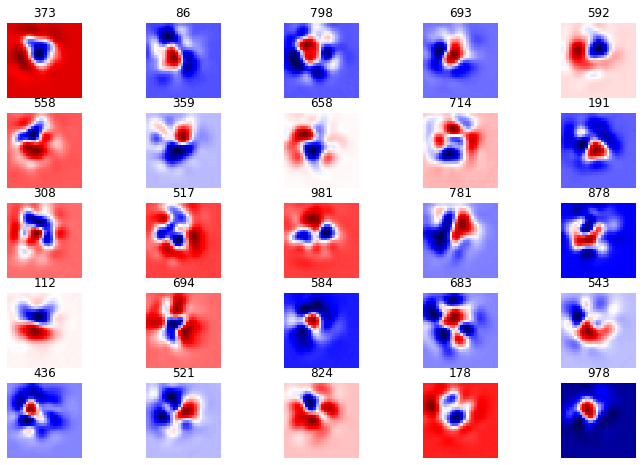

In [11]:
seed = np.random.randint(0, 1000, 25)
fig = plt.figure(figsize=(12, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    W = gabor_random_features_for_center(N, t, l, m=[10, 10], seed=seed[i])
    plt.imshow(W.reshape(n, n), cmap='seismic')
    plt.axis('off')
    ax.set_title(seed[i])

In [ ]:
seeds = [100, 272, 301] # 659, 529, 100
fig = plt.figure(figsize=(4, 2))
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    W = gabor_random_features_for_center(N, t, l, m=[10, 10], seed=seeds[i])
    W = (W - np.mean(W)) / np.std(W)
    plt.imshow(W.reshape(n, n), cmap='bwr')
    ax.set_xticks(np.linspace(0, 28, 5))
    ax.set_yticks(np.linspace(0, 28, 5))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.tick_params(direction='out', length=0, width=0, colors='k',
               grid_color='k', grid_alpha=0.5)
    plt.grid()
plt.tight_layout()
# plt.savefig('figures/deepmath/V1_receptive_field_GP.png')

In [ ]:
# plot single neuron for the colorbar
fig = plt.figure(figsize=(6, 2))
W = gabor_random_features_for_center(N, t, l, m=[10, 10], seed=seeds[i])
W = (W - np.mean(W)) / np.std(W)
plt.imshow(W.reshape(n, n), cmap='bwr')
ax.set_xticks(np.linspace(0, 28, 5))
ax.set_yticks(np.linspace(0, 28, 5))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.tick_params(direction='out', length=0, width=0, colors='k',
           grid_color='k', grid_alpha=0.5)
plt.grid()
cb = plt.colorbar(aspect=5).ax.tick_params(labelsize=20, length=0)
# plt.savefig('figures/deepmath/single_V1_receptive_field_GP.png')

### Plot MNIST

In [12]:
from mnist import MNIST
mndata = MNIST('./data/mnist/')
train, train_labels = map(np.array, mndata.load_training())
test, test_labels = map(np.array, mndata.load_testing())
train = train /255
test = test / 255
N = train.shape[1]
n = int(np.sqrt(N))

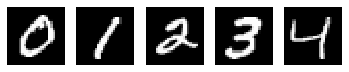

In [17]:
fig = plt.figure()
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    x = train[train_labels==i][0]
    plt.imshow(x.reshape(n, n), cmap='gray')
    plt.axis('off')
plt.savefig('figures/deepmath/MNIST_viz.png')

### Frequency detection

In [12]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [ ]:
# generate data
nPoints, fs, sig_dur = 5000, 1500, 0.1
k, a = 5, 0.8
X, y = pure_sine_dft(nPoints, fs, k, sig_dur, a, seed=20)

N = X.shape[1]
f_signal = int(k / sig_dur)
print('signal frequency=%d Hz' % f_signal)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))
print(n_features)

In [ ]:
%%time
# classification
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k - 3, highcut=k + 3)
h = relu

weights = [('bandpass_dft', f_gaus), ('white noise', None)]
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

# save
with open('figures/deepmath/freq_detect.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
mean_err_bp, std_err_bp = np.mean(results['bandpass_dft'], axis=1), np.std(results['bandpass_dft'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_bp, yerr=std_err_bp, fmt='-', label='haltere-inspired',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='classical',  
            markersize=4, lw=3)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([0, 200])
plt.xlabel('Hidden layer width', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=14)
plt.savefig('figures/deepmath/freq_detection.png')

### Frequency XOR problem

In [4]:
from sklearn.utils import shuffle
from data_fns import XOR_data

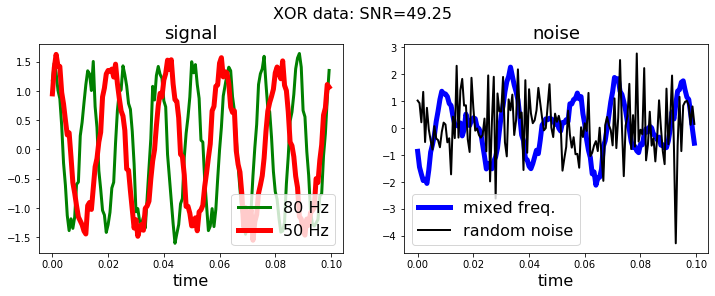

In [5]:
nPoints, fs, sig_dur = 5000, 1500, 0.1
k1, k2 = 5, 8
a = 0.99
freq = [int(k1/ sig_dur), int(k2  / sig_dur)]
X, y = XOR_data(nPoints, fs, k1, k2, sig_dur, a, seed=None)

# plot
snr = a ** 2 / (1 - a ** 2)
N = int(fs * sig_dur)
t = np.arange(N) / fs
nPoints_quarter = int(nPoints / 4)
fig = plt.figure(figsize=(12, 4))
plt.suptitle('XOR data: SNR=%0.2f' % snr, fontsize=16)
ax = fig.add_subplot(121)
plt.title('signal', fontsize=18)
plt.plot(t, X[1250], 'g', lw=3, label='%d Hz' % freq[1])
plt.plot(t, X[0], 'r', lw=5, label='%d Hz' % freq[0])
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('time', fontsize=16)


ax = fig.add_subplot(122)
plt.title('noise', fontsize=18)
plt.plot(t, X[2501], 'b', lw=5, label='mixed freq.')
plt.plot(t, X[-1], 'k', lw=2, label='random noise')
plt.legend(fontsize=16)
plt.xlabel('time', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.savefig('figures/deepmath/freq_XOR_data.png')

In [ ]:
X_perm, y_perm = shuffle(X, y, random_state=0)
# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X_perm, y_perm, test_size=0.3, random_state=42)

In [ ]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))
print(n_features)

# classification
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k1-2, highcut=k2 + 5)
weights = [('bandpass_dft', f_gaus), ('white noise', None)]

# non-linearities
h = relu

In [ ]:
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

# save
with open('figures/deepmath/freq_XOR.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# compute mean
mean_err_bp, std_err_bp = np.mean(freq_XOR['bandpass_dft'], axis=1), np.std(freq_XOR['bandpass_dft'], axis=1)
mean_err_wn, std_err_wn = np.mean(freq_XOR['white noise'], axis=1), np.std(freq_XOR['white noise'], axis=1)

In [ ]:
# plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_bp, yerr=std_err_bp, fmt='-', label='haltere-inspired',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='classical',  
            markersize=4, lw=3)
# ax.set_yscale('log')
plt.xlim([0, 200])
plt.xlabel('Hidden Layer Width', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)
plt.savefig('figures/deepmath/freq_XOR_results.png')

### MNIST classification

In [8]:
from mnist import MNIST
mndata = MNIST('./data/mnist/')
train, train_labels = map(np.array, mndata.load_training())
test, test_labels = map(np.array, mndata.load_testing())
train = train /255
test = test / 255
N = train.shape[1]
n = int(np.sqrt(N))

X_train, y_train = train.copy(), train_labels.copy()
X_test, y_test = test.copy(), test_labels.copy()

In [9]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))
print(n_features)

t = 5 # scale of bump
l = 3 # scale of wiggles

# weight function
f_gabor = lambda M, N: gabor_random_features(M, N, t, l).T
weights = [('gabor', f_gabor), ('white noise', None)]

# non-linearities
h = relu

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 19, 22, 25, 29, 33, 39, 44, 51, 59, 68, 79, 91, 104, 120, 138, 159, 184, 212, 244, 281, 323, 372, 429, 494, 568, 655, 754, 868, 1000]


In [ ]:
%%time 
results = {wt:[] for (wt, func) in weights}
for (wt, func) in weights:
    for n in n_features:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))
        print(wt, n)
# save
with open('figures/deepmath/MNIST_clf.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# compute mean
mean_err_gabor, std_err_gabor = np.mean(MNIST_clf['gabor'], axis=1), np.std(MNIST_clf['gabor'], axis=1)
mean_err_wn, std_err_wn = np.mean(MNIST_clf['white noise'], axis=1), np.std(MNIST_clf['white noise'], axis=1)

In [ ]:
# plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_gabor, yerr=std_err_gabor, fmt='-', label='V1-inspired',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='classical',  
            markersize=4, lw=3)
# ax.set_yscale('log')
# plt.xlim([0, 200])
plt.xlabel('Hidden Layer width', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)
plt.savefig('figures/deepmath/MNIST_results.png')

### MNIST Few shot learning

In [119]:
num_train = 50
X_train, _, y_train, _ = train_test_split(train, train_labels, train_size=num_train, random_state=42)
X_test, y_test = test.copy(), test_labels.copy()

In [120]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))
print(n_features)

t = 5 # scale of bump
l = 3 # scale of wiggles

# weight function
f_gabor = lambda M, N: gabor_random_features(M, N, t, l).T
weights = [('gabor', f_gabor), ('white noise', None)]

# non-linearities
h = relu

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 19, 22, 25, 29, 33, 39, 44, 51, 59, 68, 79, 91, 104, 120, 138, 159, 184, 212, 244, 281, 323, 372, 429, 494, 568, 655, 754, 868, 1000]


In [121]:
%%time 
results = {wt:[] for (wt, func) in weights}
for (wt, func) in weights:
    for n in n_features:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))
        print(wt, n)

gabor 1
gabor 2
gabor 3
gabor 4
gabor 5
gabor 6
gabor 7
gabor 8
gabor 9
gabor 10
gabor 12
gabor 14
gabor 16
gabor 19
gabor 22
gabor 25
gabor 29
gabor 33
gabor 39
gabor 44
gabor 51
gabor 59
gabor 68
gabor 79
gabor 91
gabor 104
gabor 120
gabor 138
gabor 159
gabor 184
gabor 212
gabor 244
gabor 281
gabor 323
gabor 372
gabor 429
gabor 494
gabor 568
gabor 655
gabor 754
gabor 868
gabor 1000
white noise 1
white noise 2
white noise 3
white noise 4
white noise 5
white noise 6
white noise 7
white noise 8
white noise 9
white noise 10
white noise 12
white noise 14
white noise 16
white noise 19
white noise 22
white noise 25
white noise 29
white noise 33
white noise 39
white noise 44
white noise 51
white noise 59
white noise 68
white noise 79
white noise 91
white noise 104
white noise 120
white noise 138
white noise 159
white noise 184
white noise 212
white noise 244
white noise 281
white noise 323
white noise 372
white noise 429
white noise 494
white noise 568
white noise 655
white noise 754
white n

In [126]:
# save
with open('figures/deepmath/MNIST_clf_5samp_class.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [127]:
# compute mean
mean_err_gabor, std_err_gabor = np.mean(results['gabor'], axis=1), np.std(results['gabor'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

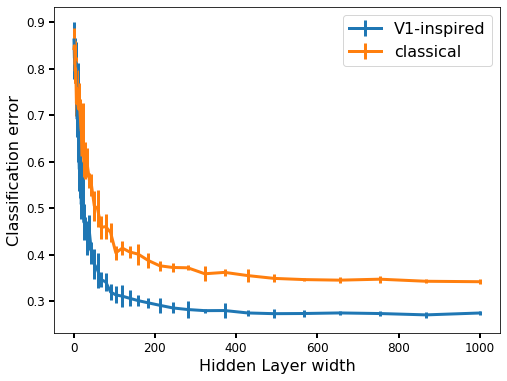

In [128]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_gabor, yerr=std_err_gabor, fmt='-', label='V1-inspired',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='classical',  
            markersize=4, lw=3)
# ax.set_yscale('log')
# plt.xlim([0, 200])
plt.xlabel('Hidden Layer width', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)